In [70]:
# Importing modules

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading 'coffee-sales.csv'

df = pd.read_csv('dataset/coffee-sales.csv')

df

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte
...,...,...,...,...,...,...
3631,2025-03-23,2025-03-23 10:34:54.894,card,ANON-0000-0000-1158,35.76,Cappuccino
3632,2025-03-23,2025-03-23 14:43:37.362,card,ANON-0000-0000-1315,35.76,Cocoa
3633,2025-03-23,2025-03-23 14:44:16.864,card,ANON-0000-0000-1315,35.76,Cocoa
3634,2025-03-23,2025-03-23 15:47:28.723,card,ANON-0000-0000-1316,25.96,Americano


In [ ]:
# Grouping 'quantity_sold' and 'revenue' based on 'coffee_name' into dataframe 'sales_summary'

sales_summary = df.groupby('coffee_name').agg(
    quantity_sold = ('coffee_name', 'count'),
    revenue = ('money', 'sum')
).reset_index()

sales_summary

,coffee_name,quantity_sold,revenue
0,Americano,578,15062.26
1,Americano with Milk,824,25269.12
2,Cappuccino,501,18034.14
3,Cocoa,243,8678.16
4,Cortado,292,7534.86
5,Espresso,134,2814.28
6,Hot Chocolate,282,10172.46
7,Latte,782,27866.30


In [ ]:
# Saving 'sales_summary' to 'sales-summary.csv'

sales_summary.to_csv('dataset/sales-summary.csv', index=False)

In [ ]:
# Grouping 'quantity' based on 'cash_type' into dataframe 'payment_method_summary'

payment_method_summary = df.groupby('cash_type').agg(
    quantity = ('cash_type', 'count')
).reset_index()

payment_method_summary

,cash_type,quantity
0,card,3547
1,cash,89


In [ ]:
# Saving 'payment_method_summary' to 'payment-method-summary.csv'

payment_method_summary.to_csv('dataset/payment-method-summary.csv', index=False)

In [43]:
# Grouping 'revenue' based on 'date' into dataframe 'daily_revenue'

df['date'] = pd.to_datetime(df['date'])

daily_revenue = df.groupby('date').agg(
    revenue = ('money', 'sum')
).asfreq('D').fillna(0).reset_index()

daily_revenue

,date,revenue
0,2024-03-01,396.30
1,2024-03-02,228.10
2,2024-03-03,349.10
3,2024-03-04,135.20
4,2024-03-05,338.50
...,...,...
383,2025-03-19,623.56
384,2025-03-20,597.60
385,2025-03-21,636.80
386,2025-03-22,365.42


In [47]:
# Creating time-based features

daily_revenue['day_of_year'] = daily_revenue['date'].dt.dayofyear
daily_revenue['day_of_week'] = daily_revenue['date'].dt.dayofweek
daily_revenue['week_of_year'] = daily_revenue['date'].dt.isocalendar().week
daily_revenue['month'] = daily_revenue['date'].dt.month

daily_revenue

,date,revenue,day_of_year,day_of_week,week_of_year,month
0,2024-03-01,396.30,61,4,9,3
1,2024-03-02,228.10,62,5,9,3
2,2024-03-03,349.10,63,6,9,3
3,2024-03-04,135.20,64,0,10,3
4,2024-03-05,338.50,65,1,10,3
...,...,...,...,...,...,...
383,2025-03-19,623.56,78,2,12,3
384,2025-03-20,597.60,79,3,12,3
385,2025-03-21,636.80,80,4,12,3
386,2025-03-22,365.42,81,5,12,3


In [48]:
# Setting X and y

X = daily_revenue[['day_of_year', 'day_of_week', 'week_of_year', 'month']]
y = daily_revenue['revenue']

In [50]:
# Training the model

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [67]:
# Revenue-forecasting function

def forecast(daily_revenue_df, model, periods=14):
    future_dates = pd.date_range(start=daily_revenue_df['date'].max() + pd.Timedelta(days=1), periods=periods)

    future_features = pd.DataFrame({
        'day_of_year': future_dates.dayofyear,
        'day_of_week': future_dates.dayofweek,
        'week_of_year': future_dates.isocalendar().week,
        'month': future_dates.month,
    })

    predicted_revenue = model.predict(future_features)

    forecast_df = pd.DataFrame({
        'date': future_dates,
        'predicted_revenue': predicted_revenue
    })

    return forecast_df

In [68]:
# Forecast-plotting function

def plotForecast(daily_revenue_df, forecast_df):
    plt.figure(figsize=(10, 4))
    plt.plot(daily_revenue_df['date'], daily_revenue_df['revenue'], label='Actual Revenue')
    plt.plot(forecast_df['date'], forecast_df['predicted_revenue'], label='Forecasted Revenue')
    plt.title('Daily Revenue Forecast')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()

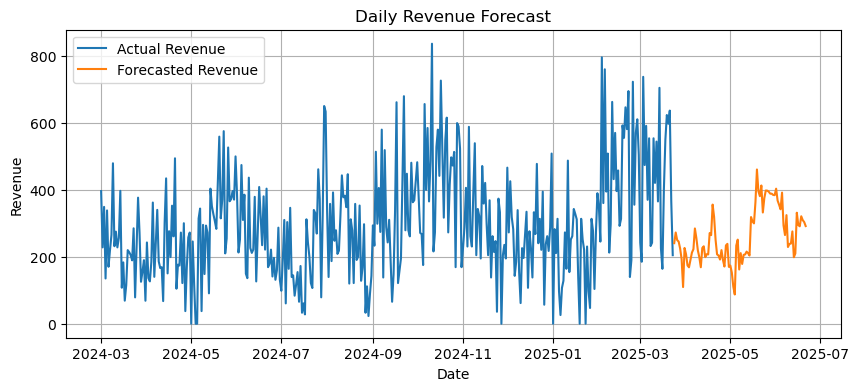

In [71]:
# Forecasting and plotting

while True:
    try:
        periods = int(input('How many days would you like to forecast (recommended = 14-90)? '))
        if periods <= 0:
            print("Please enter a positive number.")
        else:
            break
    except ValueError:
        print("Please enter a valid number.")

forecasted_revenue = forecast(daily_revenue, model, periods)
plotForecast(daily_revenue, forecasted_revenue)

forecasted_revenue.to_csv('dataset/forecasted_revenue.csv', index=False)